In [3]:
#!pip install git+https://github.com/openai/CLIP.git

In [4]:
import os
import numpy as np
from PIL import Image
import torch
import clip

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [5]:
folders = ['./trashnet-resized/paper', './trashnet-resized/cardboard',
           './trashnet-resized/glass', './trashnet-resized/metal',
           './trashnet-resized/plastic'] #, './trashnet-resized/trash'

In [6]:
# Load the model
model, preprocess = clip.load('ViT-B/32')

class_names = [os.path.basename(folder) for folder in folders]

# Prepare the inputs
images = []
labels = []

# Load the images and labels
for folder, class_name in zip(folders, class_names):
    class_images = []
    for image_name in os.listdir(folder):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(folder, image_name)
            image = Image.open(image_path)
            class_images.append(np.array(image))
    images.extend(class_images)
    labels.extend([class_names.index(class_name)] * len(class_images))

In [7]:
# Calculate features
total_accuracy = 0
y_true = []
y_score = []

with torch.no_grad():
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {class_name}") for class_name in class_names])
    text_features = model.encode_text(text_inputs)

    for folder, class_name in zip(folders, class_names):
        correct = 0
        total = 0
        y_true_class = []
        y_score_class = []

        for i in range(len(images)):
            image = images[i]
            label = labels[i]

            if label == class_names.index(class_name):
                image = Image.fromarray(image)
                image_input = preprocess(image).unsqueeze(0)

                image_features = model.encode_image(image_input)
                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                values, indices = similarity[0].topk(1)

                total += 1
                if indices.item() == class_names.index(class_name):
                    correct += 1

                y_true_class.append(1)
                y_score_class.append(similarity[0][class_names.index(class_name)].item())
            else:
                y_true_class.append(0)
                y_score_class.append(similarity[0][class_names.index(class_name)].item())

        accuracy = 100 * correct / total
        total_accuracy += accuracy
        print(f"{class_name:>16s}: {accuracy:.2f}%")

        y_true.extend(y_true_class)
        y_score.extend(y_score_class)

total_accuracy /= len(class_names)
print(f"total accuracy: {total_accuracy:.2f}%")

           paper: 83.73%
       cardboard: 90.07%
           glass: 58.72%
           metal: 33.01%
         plastic: 91.01%
total accuracy: 71.31%


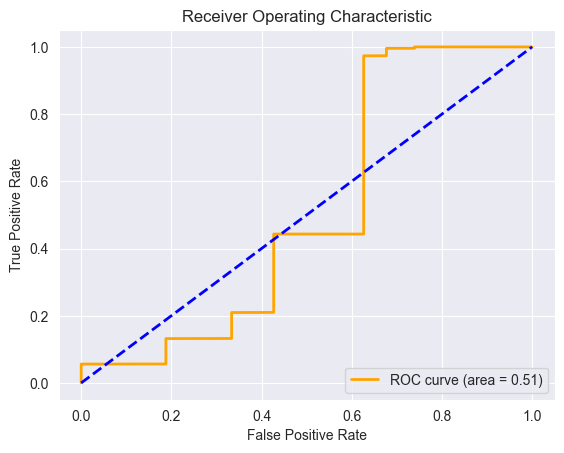

In [8]:
# Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()